## CEMRACS 2025 - Hands-on session
# Quantum chemistry with short-term & long-term quantum algorithms

The goal of this hands-on session is to give you a flavor of two algorithms for handling ground-state energy estimation problems such as the ones arising in quantum chemistry: given a Hamiltonian $H$, we want to find its ground state energy $E_0$, namely its lowest eigenvalue.

Two main algorithms have been proposed to this avail: the quantum phase estimation (QPE) algorithm, and the variational quantum eigensolver (VQE) algorithm. The former is aimed at noiseless (or error-corrected) quantum processors, while the second is aimed as noisy quantum processors, aka NISQ processors.

## Prerequisite: spin-fermion transforms

Chemistry describes the behavior of electrons, which are fermionic particles. Their algebraic properties differ from those of qubits: $N$ fermionic spin-orbitals are described by a $2^N$-dimensional Fock space with a basis $|n_1, n_2, \dots, n_N\rangle$ defined as the eigenbasis of the so-called number operators $\hat{n}_i = c^\dagger_i c_i$ ($i=1\dots N$) with 
$$ \hat{n}_i |n_1, n_2, \dots, n_N\rangle = n_i |n_1, n_2, \dots, n_N\rangle, $$
with $n_i \in \lbrace 0 , 1 \rbrace$.

The creation (resp. annihilation) operators create (resp. annihilate) electrons:
$$ c^\dagger_i |n_1, n_2, \dots, n_i, \dots, n_N\rangle = (-)^{\sum_{k<i} n_k} |n_1, n_2, \dots, 1, \dots, n_N\rangle $$
if $n_i=0$, and $=0$ otherwise.
$$ c_i |n_1, n_2, \dots, n_i, \dots, n_N\rangle = (-)^{\sum_{k<i} n_k} |n_1, n_2, \dots, 0, \dots, n_N\rangle $$
if $n_i=1$, and $=0$ otherwise.
Note the $(-)^{\sum_{k<i} n_k}$ factor: it is the signature of the fermionic antisymmetric behavior, and illustrates that this Fock space is not a tensor product of  $N$ two-level systems (aka qubits)!

Finally, these operators obey anticommutation relations:
$$ \lbrace c^{(\dagger)}_i, c^{(\dagger)}_j \rbrace = 0$$
$$ \lbrace c_i, c^\dagger_j \rbrace =  \delta_{ij},$$
with $\lbrace  A,B \rbrace = AB + BA$.

The Hamiltonian of a molecule is described in terms of these operators:

$$ H = \sum_{pq} h_{pq} c^\dagger_p c_q + \frac{1}{2} \sum_{pqrs} h_{pqrs} c^\dagger_p c^\dagger_q c_r c_s $$

with the $h_{pq}$ and $h_{pqrs}$ ($p,q,r,s \in 1.. N$) tensors being specific to a given molecule. 

On the other hand, $N$ qubits are described by a $2^N$-dimensional Hilbert space, itself a tensor product of  $N$ qubits, with a $|b_1\rangle \otimes |b_2\rangle \otimes \cdots |b_N\rangle$ tensor basis, with $\sigma_z^{(i)} |b_i\rangle = (-)^{b_i} |b_i\rangle$ (with $b_i \in \lbrace 0 , 1 \rbrace$.). We are now looking for a one-to-one mapping between operators of the Fock space (e.g $c^\dagger_i$)  and operators of the Hilbert space (let us call them e.g $\tilde{c}^\dagger_i$).

The simplest such mapping, called Jordan-Wigner encoding, maps the Fock basis onto the Hilbert basis via the simple correspondence
$$ b_i = n_i, \forall i$$
As for operators, one can check that
$$ \tilde {c}^\dagger_i  = \left (\bigotimes_{k=1}^{i-1} \sigma_z^{(i)} \right ) \otimes \frac{1}{2} (\sigma_x^{i} -j \sigma_y^{(i)}) $$

has the same action on $|b_1\rangle \otimes |b_2\rangle \otimes \cdots |b_N\rangle$ as $c_i^\dagger$ on $|n_1, n_2, \dots, n_N\rangle$. Note how an operator seemingly local in a fermionic context ($c_i^\dagger$) becomes non-local (in the sense that it acts on several qubits) when written in a qubit context.

Using these definitions, myQLM provides automatic conversion tools from $H$ given in terms of fermionic creation and annihilation operators to its qubit version, which will generically be in the form $\tilde H = \sum_i \lambda_i P_i $, with $P_i$ a product of Pauli ($x,y,z$) operators, and $\lambda_i \in \mathbb{R}$.

## A concrete example: the H$_2$ molecule.

The H$_2$ molecule is a simple, yet interesting example of molecule. It is often used as a testbed for quantum chemical methods. In particular, classical methods often struggle with its "dissociation limit", namely when the two atoms are far from each other.

In the cell below, we define the H$_2$ geometry, with a fixed distance $r=0.7414 \dot{A}$. We use a Python quantum chemistry package called ``PySCF`` to compute the $h_{pq}$ and $h_{pqrs}$ tensors. PySCF also implements a few classical methods like Hartree-Fock (HF), Moller-Plesset (MP2), and full configuration interaction (FCI). The latter gives the exact ground state energy. It can be done because H$_2$ is a small system, but for larger molecules FCI is usually out of reach. (For these molecules the option ``run_fci`` should be turned off).

In [1]:
from qat.fermion.chemistry.pyscf_tools import perform_pyscf_computation
geometry = [("H", (0.0, 0.0, 0.0)), ("H", (0.0, 0.0, 0.7414))]
basis, spin, charge = "sto-3g", 0, 0

(
    rdm1,
    orbital_energies,
    nuclear_repulsion,
    n_electrons,
    one_body_integrals,
    two_body_integrals,
    info,
) = perform_pyscf_computation(geometry=geometry, basis=basis, spin=spin, charge=charge, run_fci=True)

print(
    f" HF energy :  {info['HF']}\n",
    f"MP2 energy : {info['MP2']}\n",
    f"FCI energy : {info['FCI']}\n",
)
nqbits = rdm1.shape[0] * 2
print("Number of orbitals (qubits) = ", nqbits)

from qat.fermion.chemistry import MolecularHamiltonian, MoleculeInfo
mol_h = MolecularHamiltonian(one_body_integrals, two_body_integrals, nuclear_repulsion)
hamiltonian = mol_h.get_electronic_hamiltonian()
print(hamiltonian)

/home/tayral/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:542: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


 HF energy :  -1.1166843870853405
 MP2 energy : -1.1298551535553094
 FCI energy : -1.1372701746609035

Number of orbitals (qubits) =  4
0.7137539936876182 * I^4 +
(-1.2524635735648983+0j) * (Cc|[0, 0]) +
(-1.2524635735648983+0j) * (Cc|[1, 1]) +
(-0.4759487152209643+0j) * (Cc|[2, 2]) +
(-0.4759487152209643+0j) * (Cc|[3, 3]) +
(-0.6744887663568379+0j) * (CCcc|[0, 1, 0, 1]) +
(-0.18128880821149598+0j) * (CCcc|[0, 1, 2, 3]) +
(-0.48217928821207207+0j) * (CCcc|[0, 2, 0, 2]) +
(-0.663468096423568+0j) * (CCcc|[1, 2, 1, 2]) +
(0.18128880821149598+0j) * (CCcc|[1, 2, 0, 3]) +
(-0.663468096423568+0j) * (CCcc|[0, 3, 0, 3]) +
(0.18128880821149598+0j) * (CCcc|[0, 3, 1, 2]) +
(-0.48217928821207207+0j) * (CCcc|[1, 3, 1, 3]) +
(-0.18128880821149598+0j) * (CCcc|[2, 3, 0, 1]) +
(-0.6973937674230271+0j) * (CCcc|[2, 3, 2, 3])


### Fermion-qubit conversion

We now perform the fermion-to-qubit conversion. The default mapping is Jordan-Wigner, but you can try others.

In [2]:
hamiltonian_qubit = hamiltonian.to_spin() # default is Jordan Wigner
print(hamiltonian_qubit)

(-0.09886396933545832+0j) * I^4 +
(0.16862219158920946+0j) * (ZZ|[0, 1]) +
(0.12054482205301802+0j) * (ZZ|[0, 2]) +
(0.165867024105892+0j) * (ZZ|[1, 2]) +
(0.165867024105892+0j) * (ZZ|[0, 3]) +
(0.17119774903432972+0j) * (Z|[0]) +
(0.12054482205301802+0j) * (ZZ|[1, 3]) +
(0.17119774903432972+0j) * (Z|[1]) +
(0.045322202052873996+0j) * (XYYX|[0, 1, 2, 3]) +
(-0.045322202052873996+0j) * (XXYY|[0, 1, 2, 3]) +
(-0.045322202052873996+0j) * (YYXX|[0, 1, 2, 3]) +
(0.045322202052873996+0j) * (YXXY|[0, 1, 2, 3]) +
(0.17434844185575676+0j) * (ZZ|[2, 3]) +
(-0.2227859304041846+0j) * (Z|[2]) +
(-0.2227859304041846+0j) * (Z|[3])


## Exact result

For comparison with the two quantum methods we are about to implement, let us solve the problem exactly: since it is a small molecule (= small number of orbitals), we can afford to diagonalize the corresponding Hamiltonian exactly. How does the lowest eigenenergy compare with the "FCI" energy printed above? 

In [3]:
import numpy as np

# extract the matrix representation of the Hamiltonian (can make it sparse, see docstring of get_matrix)
ham_matrix = hamiltonian_qubit.get_matrix()

# diagonalize
eigvals = np.linalg.eigvalsh(ham_matrix)
E0 = min(eigvals)
print("E0 = ", E0)

E0 =  -1.1372701746609029


## NISQ: the variational quantum eigensolver

Take a hardware-efficient ansatz, with an alternation of walls of $R_y$ rotations and walls of CNOT gates.

In [4]:
from qat.lang.AQASM import RY, CNOT, Program

def generate_ansatz(n_layers):
    prog = Program()
    qreg = prog.qalloc(nqbits)
    
    for id_layer in range(n_layers):
        for qb in range(nqbits):
            prog.apply(RY(prog.new_var(float, f"\\theta_{nqbits*id_layer+qb}")), qb)
        for qb in range(nqbits-1):
            prog.apply(CNOT, qreg[qb], qreg[qb+1])
    
    circ = prog.to_circ()
    return circ

n_layers = 3
circ = generate_ansatz(n_layers)
circ.display()

We now implement the VQE per se.

In [5]:
from qat.qpus import get_default_qpu
from qat.plugins import ScipyMinimizePlugin

def perform_vqe(circ, nbshots, qpu, method="bfgs"):
    """
    This function performs the VQE algorithm for a given variational circuit and quantum processor.

    Args:
        circ (Circuit): variational circuit
        nbshots (int): number of shots 
        qpu (QPUHandler): a quantum processor (emulator, or experimental one)

    Returns:
        Result: an object containing the results (including the variational energy)
    """
    
    # define the plugin (optimization module)
    # the optimization method can be picked from the various methods implemented in scipy.optimize.minimize, see online doc
    plugin = ScipyMinimizePlugin(method=method,
                                 x0 = [np.random.rand() for _ in range(n_layers*nqbits)],
                                 options={'maxiter': 500})
    # define the stack
    stack = plugin | qpu
    
    # create a job with a parametric circuit and hamiltonian to be optimized
    # here nbshots will control the number of shots per term of the Hamiltonian
    # (thus the total number of shots is nbshots x number of terms)
    job = circ.to_job(observable=hamiltonian_qubit, nbshots=nbshots)
    
    # submit the job (=perform the computation)
    res = stack.submit(job)

    return res

# instantiate the default QPU emulator: a perfect circuit emulator
qpu = get_default_qpu()

res = perform_vqe(circ, 0, qpu)
print("variational energy = ", res.value)

variational energy =  -1.1372701744322027


Let us plot the evolution of the energy along the optimization procedure.

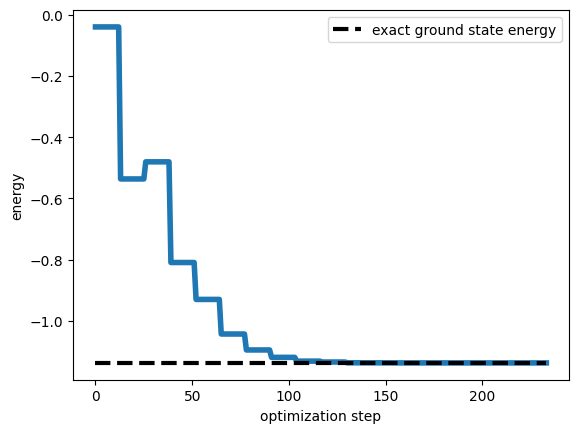

In [6]:
import matplotlib.pyplot as plt
optimization_trace = eval(res.meta_data["optimization_trace"])

plt.plot(optimization_trace, '-', lw=4)
plt.plot([E0]*len(optimization_trace), '--k', lw=3, label="exact ground state energy")
plt.xlabel("optimization step")
plt.ylabel("energy")
plt.legend();

Let us look at the corresponding state by extracting the optimized parameters and running the corresponding circuit.

In [7]:
# extract the optimized parameters
pmap = eval(res.meta_data["parameter_map"])
print("optimized parameters:", pmap)
sol_circ = circ(**pmap)
qpu = get_default_qpu()
res2 = qpu.submit(sol_circ.to_job())
for sample in res2:
    if abs(sample.amplitude)>1e-1:
        print(f"{sample.state} ({sample.state.int}): {sample.amplitude}")

optimized parameters: {'\\theta_0': 2.6893894100172804, '\\theta_1': -0.06613311060628065, '\\theta_10': 1.2210053797787144, '\\theta_11': -0.06413240125502888, '\\theta_2': 1.570787550813338, '\\theta_3': 0.35539079079672214, '\\theta_4': -0.03210478333449806, '\\theta_5': -0.07348208811388075, '\\theta_6': 1.3968452861451626, '\\theta_7': 1.3855353907338779, '\\theta_8': 0.6772770996894059, '\\theta_9': -2.626885793134871e-07}
|0011> (3): (-0.1128269814371377+0j)
|1100> (12): (0.9936146496204724+0j)


### Check: exact ground state

For comparison, let us print the exact ground state wavevector that we get through exact diagonalization.

In [8]:
eigvals, eigvecs = np.linalg.eigh(ham_matrix)
psi0 = eigvecs[:, np.argmin(eigvals)]
print("Psi0:", psi0)

Psi0: [ 0.        +0.j  0.        +0.j  0.        +0.j  0.11282737+0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
 -0.99361461+0.j  0.        +0.j  0.        +0.j  0.        +0.j]


### Influence of the number of shots on the energy estimation

100 -1.141135718484212
500 -1.1361100643545485
1000 -1.129116454764365
10000 -1.1385003599862593
50000 -1.1371525036670502


Text(0, 0.5, 'converged energy')

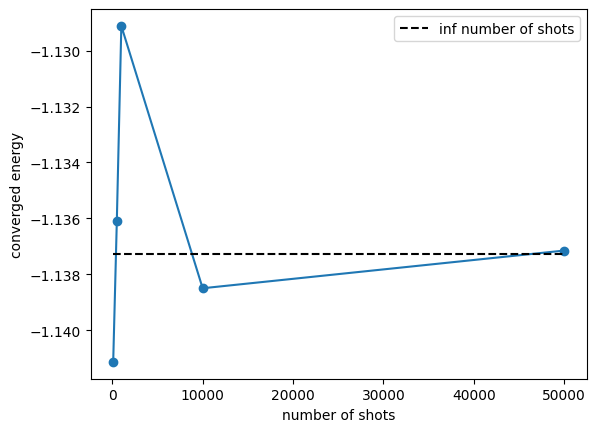

In [9]:
sol_circ = circ(**pmap)
qpu = get_default_qpu()
nshot_list = [100, 500, 1000, 10000, 50000]

value_list = []
for nshots in nshot_list:
    res3 = qpu.submit(sol_circ.to_job(observable=hamiltonian_qubit, nbshots=nshots))
    print(nshots, res3.value)
    value_list.append(res3.value)

plt.plot(nshot_list, value_list, '-o')
plt.plot(nshot_list, [res.value]*len(value_list), '--k', label="inf number of shots")
plt.legend()
plt.xlabel("number of shots")
plt.ylabel("converged energy")

### Influence of shot noise on the optimization

Let us now look at the influence of a finite number of shots to compute the estimate of the energy.

In [10]:
n_layers = 3
circ = generate_ansatz(n_layers)
qpu = get_default_qpu()
nshot_list = [500, 1000, 10000, 20000, 50000]

value_list = []
for nshots in nshot_list:
    res = perform_vqe(circ, nbshots=nshots, qpu=qpu, method="COBYLA") # we switch to COBYLA because bfgs is too sensitive to shot noise
    print(nshots, res.value)
    value_list.append(res.value)

res = perform_vqe(circ, nbshots=0, qpu=qpu)
inf_nshots = res.value

500 -0.8419137674708442
1000 -0.9912143600894742
10000 -1.1347455263498207
20000 -1.1337868650989045
50000 -1.1369465942090218


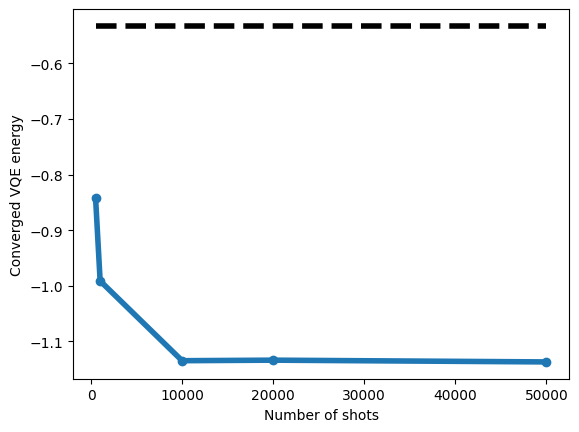

In [11]:
plt.plot(nshot_list, value_list, '-o', lw=4)
plt.plot(nshot_list, [inf_nshots]*len(value_list), '--k', lw=4, label = "exact value")
plt.ylabel("Converged VQE energy")
plt.xlabel("Number of shots");


### Barren plateaux?

Here we investigate the possible existence of barren plateaux by increasing the number of layers. Starting from a random initial guess, this should produce a more and more random state and thus favor barren plateaux. (Yet, here the number of qubits is quite low...)

In [12]:
qpu = get_default_qpu()
n_layer_list = [2, 3, 5, 10, 20]
value_list_nl = []
for n_layers in n_layer_list:
    circ = generate_ansatz(n_layers)
    res = perform_vqe(circ, 1000, qpu, "COBYLA")
    print(n_layers, res.value)
    value_list_nl.append(res.value)
    

2 -0.5040123416216896
3 -1.1287811744125338
5 -0.986202080737369
10 -0.8000021594316069
20 -1.1331764246532037


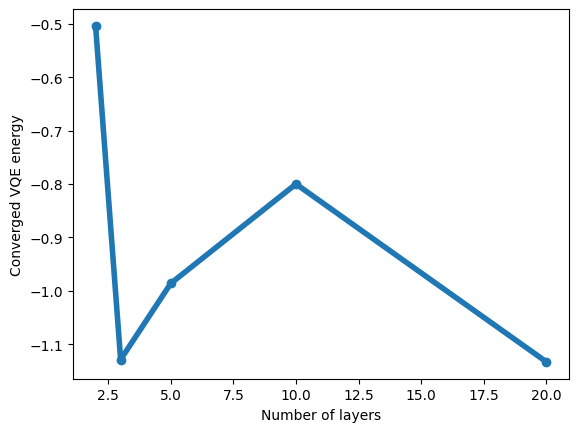

In [13]:
plt.plot(n_layer_list, value_list_nl, '-o', lw=4)
plt.ylabel("Converged VQE energy")
plt.xlabel("Number of layers");


### With decoherence

We now turn to the influence of decoherence. Here, we create a "noisy" emulator that adds depolarizing noise after each gate of the circuit.

How does the final energy compare with the final energy obtained in the absence of noise?

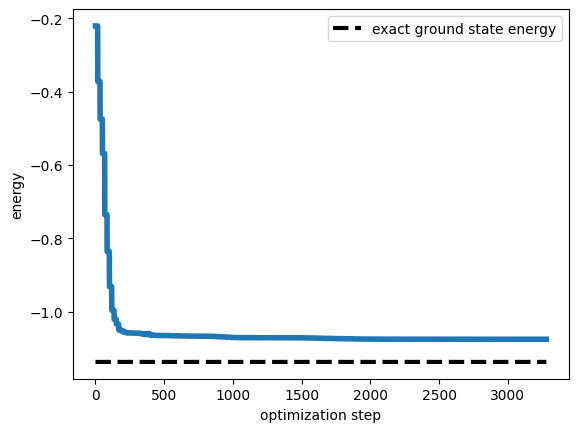

In [14]:
from depolarizing_plugin_vec import DepolarizingPluginVec

# we instantiate a plugin that turns a perfect qpu into a noisy qpu:
depol = DepolarizingPluginVec(prob_1qb=0.005, prob_2qb=0.001)  # 0.005 corresponds to 0.5% probability
qpu = get_default_qpu()

noisy_qpu = depol | qpu

n_layers = 4
circ = generate_ansatz(n_layers)


res = perform_vqe(circ, 0, noisy_qpu)
optimization_trace = eval(res.meta_data["optimization_trace"])

plt.plot(optimization_trace, '-', lw=4)
plt.plot([E0]*len(optimization_trace), '--k', lw=3, label="exact ground state energy")
plt.xlabel("optimization step")
plt.ylabel("energy")
plt.legend();


## Quantum phase estimation

In this second part we turn to QPE.

As we learned in the lecture, to apply QPE to the estimation of the ground state energy, we need a good input state (namely a state with a large overlap with the ground state). Here, we will assume our input state is the ground state itself. We can decide on an arbitrary input state by using a special gate called a "state preparation" gate, that directly loads the vector on the quantum register.

We also need to slightly redefine the Hamiltonian and pick the evolution time in the $e^{-i(H-\tilde{E})t}$ unitary so that the phase to be estimated by QPE is comprised within the $[0, 1[$ interval. If we now that $E_0$ is within an energy window $[E_{min},E_{max}]$, then a shift $\tilde{E} = E_{min}$ and $t = -2\pi / (E_{max} - E_{min})$ will achieve this condition.


In [15]:
# test of AbstractGate: to perform time evolutions exactly.

import scipy as sp
from qat.lang.AQASM import AbstractGate
from qat.lang.AQASM import X
t0 = 1.0
mat_U = sp.linalg.expm(-1j*hamiltonian_qubit.get_matrix() *t0)
U = AbstractGate("U", [], matrix_generator=lambda mat_U=mat_U: mat_U)

prog = Program()
reg = prog.qalloc(hamiltonian_qubit.nbqbits)
prog.apply(X, reg[2])
prog.apply(X, reg[3])
prog.apply(U(), reg)
circ = prog.to_circ()
res = qpu.submit(circ.to_job())
for sample in res:
    print(sample.state, sample.amplitude)
print(mat_U[:,3])

|0011> (0.88112570621605-0.4442048383430136j)
|1100> (0.052353622063593674-0.15348827217330527j)
[0.        +0.j         0.        +0.j         0.        +0.j
 0.88112571-0.44420484j 0.        +0.j         0.        +0.j
 0.        +0.j         0.        +0.j         0.        +0.j
 0.        +0.j         0.        +0.j         0.        +0.j
 0.05235362-0.15348827j 0.        +0.j         0.        +0.j
 0.        +0.j        ]


In [16]:
# state preparation followed by abstract gate
from qat.qpus import PyLinalg, CLinalg

StatePreparation = AbstractGate("STATE_PREPARATION", [np.ndarray])
mat_U = sp.linalg.expm(-1j*hamiltonian_qubit.get_matrix() *t0)
U = AbstractGate("U", [], matrix_generator=lambda: mat_U)

prog = Program()
reg = prog.qalloc(hamiltonian_qubit.nbqbits)
prog.apply(StatePreparation(psi0), reg)
prog.apply(U(), reg)
circ = prog.to_circ()
qpu = PyLinalg()

res = qpu.submit(circ.to_job())
for sample in res:
    print(sample.state.int, sample.amplitude)

print("U psi0:", mat_U@psi0)

3 (0.04739577138595119+0.1023897259727182j)
12 (-0.41739102170780124-0.9016954695836505j)
U psi0: [ 0.        +0.j          0.        +0.j          0.        +0.j
  0.04739577+0.10238973j  0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
 -0.41739102-0.90169547j  0.        +0.j          0.        +0.j
  0.        +0.j        ]


In [17]:
from qat.lang.AQASM.qftarith import IQFT
from qat.lang.AQASM import H, QRoutine, RX, Program
from qat.lang.AQASM import CNOT, RZ

def construct_Pauli_evolution(ops, qbits, theta):
    r"""Implements the quantum routine
    
    .. math::
         R_k(\theta) = \exp\left(-i \frac{\theta}{2} P_k\right)
         
    with P_k a Pauli string
    
    Args:
        ops (str): Pauli operators (e.g X, Y, ZZ, etc.)
        qbits (list<int>): qubits on which they act
        theta (Variable): the abstract variable
        
    Returns:
        QRoutine
        
    Notes:
        the indices of the wires of the QRoutine are relative
        to the smallest index in qbits (i.e always start at qb=0)
    """
    qrout = QRoutine()
    qreg = qrout.new_wires(len(qbits))
    with qrout.compute():
        for op, qbit in zip(ops, qreg):
            if op == "X":
                qrout.apply(H, qbit)
            if op == "Y":
                qrout.apply(RX(np.pi/2), qbit)
        for ind_qb in range(len(qreg)-1):
            qrout.apply(CNOT, qreg[ind_qb], qreg[ind_qb+1])
    qrout.apply(RZ(theta.real), qreg[-1])
    # uncompute() applies U^dagger,
    # with U the unitary corresponding to the gates applied within the "with XX.compute()" context
    qrout.uncompute()
    
    return qrout


def make_controlled_evolution(hamiltonian, t0, n_trotter, order):
    """contruct controlled-U with :math:`U = \exp(-i H t0)`

    Args:
        hamiltonian (Observable): the Hamiltonian H
        t0 (float): the evolution time
        n_trotter (int): the number of Trotter slices
        order (int): the Trotterization order (1 or 2)

    Returns:
        QRoutine: the U routine
    """
    routine = QRoutine()
    anc_reg = routine.new_wires(1)
    data_reg = routine.new_wires(hamiltonian.nbqbits)
    
    routine.apply(RZ(-hamiltonian.constant_coeff.real*t0), anc_reg) # controlled-global-phase (up to global phase)
    
    for _ in range(n_trotter):
        if order == 1:
            for term in hamiltonian.terms:
                theta = 2 * term.coeff * t0 / n_trotter
                Rk_routine = construct_Pauli_evolution(term.op, term.qbits, theta)
                
                routine.apply(Rk_routine.ctrl(), anc_reg,
                              [data_reg[qb] for qb in term.qbits])
                
        elif order == 2:
            for term in hamiltonian.terms:
                theta = term.coeff * t0 / n_trotter
                Rk_routine = construct_Pauli_evolution(term.op, term.qbits, theta)
                routine.apply(Rk_routine.ctrl(), anc_reg,
                              [data_reg[qb] for qb in term.qbits])
                
            for term in reversed(hamiltonian.terms):
                theta = term.coeff * t0 / n_trotter
                Rk_routine = construct_Pauli_evolution(term.op, term.qbits, theta)
                routine.apply(Rk_routine.ctrl(), anc_reg,
                              [data_reg[qb] for qb in term.qbits])
            
    return routine


In [18]:
from qat.lang.AQASM.qftarith import IQFT
from qat.lang.AQASM import H, QRoutine, RZ, Program

def build_qpe_routine_for_hamiltonian(hamiltonian, n_phase_bits, t0=1., exact_evolution=False, n_trotter=1, order=1):
    """Construct the quantum phase estimation routine corresponding to a given Hamiltonian
    
    Args:
        hamiltonian (Observable): a Hamiltonian
        n_phase_bits (int): the number of phase bits
        t0 (float): the evolution time
        exact_evolution (bool, optional): whether to implement U=exp(-i H t0) exactly. Defaults to False
        n_trotter (int): the number of Trotter steps
        order (int): Trotterization order
        
    Returns:
        QRoutine: a quantum routine for phase estimation with unitary U = exp(-i H t0)
    """
    routine = QRoutine()
    phase_reg = routine.new_wires(n_phase_bits)
    data_reg = routine.new_wires(hamiltonian.nbqbits)
    
    # Hadamard wall
    for qb in range(n_phase_bits):
        routine.apply(H, phase_reg[qb])
    
    # controlled unitaries
    for j_ind in range(n_phase_bits):
        
        if exact_evolution:
            mat_U = sp.linalg.expm(-1j*hamiltonian.get_matrix() * 2**j_ind * t0)
            U = AbstractGate(f"U_{j_ind}", [], matrix_generator=lambda mat_U=mat_U: mat_U)
            routine.apply(U().ctrl(), phase_reg[j_ind], data_reg)
        else:
            routine.apply(make_controlled_evolution(hamiltonian, 2**j_ind * t0, n_trotter, order),
                          phase_reg[j_ind], data_reg)

    # now apply inverse QFT
    routine.apply(IQFT(n_phase_bits), phase_reg)
    
    return routine

qpe_routine = build_qpe_routine_for_hamiltonian(hamiltonian_qubit, 3, t0=1., n_trotter=1)
qpe_routine.display(depth=0)

In [19]:
def perform_qpe(qpu, hamiltonian, psi0, n_phase_bits, exact_evolution=False,
                n_trotter=10, nbshots=0, t0=1.0, order=1, verbose=False):
    """
    Args:
        qpu (QPU): a QPU
        hamiltonian (Observable): a Hamiltonian
        psi0 (np.array): an eigenvector of H
        n_phase_bits (int): number of bits for the phase
        exact_evolution (bool, optional): whether to implement U=exp(-i H t0) exactly. Defaults to False
        n_trotter (int, optional): number of trotter slices. Defaults to 10
        nbshots (int, optional): number of shots.
            Defaults to 0 (corresponding to an infinite number of shots)
        t0 (float, optional): time in U = exp(- i H t0). Defaults to 1.
        order (int, optional): Trotterization order. Defaults to 1.
        verbose (bool, optional): for verbose output. Defaults to False.
        
    Returns:
        np.array: the vector of probabilities (frequencies) of obtaining each output (from 0 to 2^{m-1})
    """
    # we prepare the initial state |0...0>|psi0> of the register
    phase_reg_in = np.zeros((2**n_phase_bits,))
    phase_reg_in[0] = 1.0 # |0...0>
    psi_init = np.kron(phase_reg_in, psi0) 
    
    # we initialize the program
    prog = Program()
    phase_reg = prog.qalloc(n_phase_bits)
    data_reg = prog.qalloc(hamiltonian.nbqbits)

    # we use a StatePreparation gate to prepare psi_init
    # this is somewhat of a trick: this assumes we can prepare exactly the ground state
    # if we don't want to cheat we can replace the StatePreparation routine
    # by a routine (gates) that prepare an approximate ground state
    prog.apply(StatePreparation(psi_init), phase_reg, data_reg)

    # we call the main QPE routine
    pea_routine = build_qpe_routine_for_hamiltonian(hamiltonian, n_phase_bits, t0=t0,
                                                    exact_evolution=exact_evolution,
                                                    n_trotter=n_trotter, order=order)
    prog.apply(pea_routine, phase_reg, data_reg)

    # we generate the corresponding circuit and execute it
    circ = prog.to_circ()

    res = qpu.submit(circ.to_job(nbshots=nbshots, qubits=phase_reg)) #measure only phase register

    # we store the output probabilities in a vector
    probs = np.zeros(2**n_phase_bits)

    for sample in res:
        probs[sample.state.int] = sample.probability


    return probs

In [20]:
eigvals, eigvecs = np.linalg.eigh(hamiltonian_qubit.get_matrix())
print("min, max:", min(eigvals), max(eigvals))
psi0 = eigvecs[:, np.argmin(eigvals)]

Emin = min(eigvals) - 0.5 # lower than lowest eigval
Emax = max(eigvals) + 0.5 # higher than highest eigval

hamiltonian_qubit_offset = hamiltonian_qubit - Emax # this way all eigvals are negative, so phase - E t is positive
t0 = 2*np.pi/ abs(Emin - Emax) # ensures phi = -E t / 2pi is within [0, 1[
print("t0 :", t0)

# expected phase?
exp_phase = -(E0 - Emax)*t0 / (2*np.pi)
print("expected phase (with floating point precision):", exp_phase)

min, max: -1.1372701746609029 0.9201067191670376
t0 : 2.055090204895486
expected phase (with floating point precision): 0.8364611176955737


estimated energy = -1.1595550350002868
E0 =  -1.1372701746609029


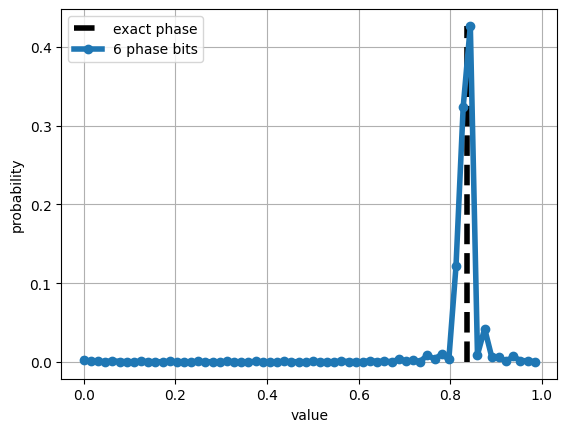

In [21]:
import itertools
qpu = PyLinalg()
n_phase_bits = 6
n_trotter = 20

probs = perform_qpe(qpu, hamiltonian_qubit_offset, psi0, n_phase_bits, exact_evolution=False,
                    n_trotter=n_trotter, t0=t0, order=1, verbose=False)

indmax = np.argmax(probs)
phase = indmax / 2**n_phase_bits
energy = - 2*np.pi*phase/t0 + Emax

print("estimated energy =", energy)
print("E0 = ", E0)

plt.plot([exp_phase, exp_phase], [0, max(probs)], '--k', lw=4, label = "exact phase")

plt.plot(np.linspace(0, 1, 2**n_phase_bits, endpoint=False), probs, '-o', lw=4, label="%s phase bits"%n_phase_bits)


plt.legend()
plt.xlabel("value")
plt.ylabel("probability")
plt.grid();


### Influence of the number of phase bits

In [22]:
n_phase_bits_list = [4, 6, 8, 10]
energy_list = []
for n_phase_bits in n_phase_bits_list:
    n_trotter = 30
    probs = perform_qpe(qpu, hamiltonian_qubit_offset, psi0, n_phase_bits, exact_evolution=True,
                        n_trotter=10, t0=t0, order=1, verbose=False)

    indmax = np.argmax(probs)
    phase = indmax / 2**n_phase_bits
    energy = - 2*np.pi*phase/t0 + Emax
    print(f"[{n_phase_bits}] energy: {energy}")
    energy_list.append(energy)


[4] energy: -1.0640120070681638
[6] energy: -1.1595550350002868
[8] energy: -1.135669278017256
[10] energy: -1.1386549976401348


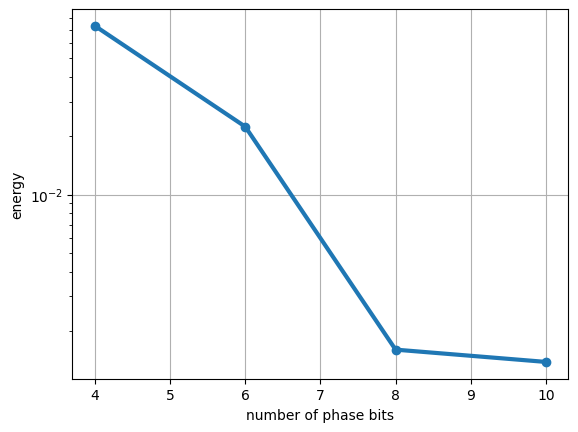

In [23]:
plt.plot(n_phase_bits_list, abs(np.array(energy_list)-E0), '-o', lw=3)
plt.xlabel("number of phase bits")
plt.ylabel("energy")
plt.grid()
plt.yscale("log")